### New York Taxi Fare Scablable Analysis

#### Importing Required Libraries

In [2]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark import SparkConf
import logging
import warnings
import pandas as pd
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
import plotly.express as px

# Suppress warnings to ensure cleaner output logs
warnings.filterwarnings('ignore')

#### Initialize Spark session

In [3]:
# Initialize Spark session with a specific application name and configuration
spark = SparkSession.builder.appName("New York Taxi Fare Scablable Analysis").getOrCreate()

# Set Spark log level to WARN to minimize log output for cleaner execution visibility
spark.sparkContext.setLogLevel("WARN")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/17 15:45:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Load the New York Taxi Fare dataset from HDFS
taxi_fare_data = spark.read.csv("hdfs://ssp-master:54310/ssp/train.csv", header=True, inferSchema=True)

In [5]:
# Display the schema of the dataset to verify its structure
taxi_fare_data.printSchema()

root
 |-- key: timestamp (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



In [6]:
# Display the first few rows of the dataset
taxi_fare_data.show(5)

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15 17:26:21|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|
|2010-01-05 16:52:16|       16.9|2010-01-05 16:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|
|2011-08-18 00:35:00|        5.7|2011-08-18 00:35:00|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|
|2012-04-21 04:30:42|        7.7|2012-04-21 04:30:42|       -73.98713|      40.733143|       -73.991567|       40.758092|              1|
|2010-03-09 07:51:00|        5.3|2

In [9]:
row_count = taxi_fare_data.count()
print(f"Row Count: {row_count}")

Row Count: 55423856


#### Descriptive statistics

In [119]:
# Descriptive statistics for numeric fields
taxi_fare_data.describe().show()

# Checking for the number of unique values in categorical columns
taxi_fare_data.select("passenger_count").distinct().show()

# Checking the distribution of fare amounts
taxi_fare_data.select("fare_amount").summary("count", "min", "25%", "50%", "75%", "max").show()

24/08/19 22:28:30 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/08/19 22:28:32 WARN BlockReaderFactory: I/O error constructing remote block reader.
java.io.IOException: Got error, status=ERROR, status message opReadBlock BP-47748722-10.128.0.2-1723838572402:blk_1073741847_1024 received exception java.io.FileNotFoundException: BlockId 1073741847 is not valid., for OP_READ_BLOCK, self=/10.128.0.2:53312, remote=/10.128.0.2:9866, for file /ssp/train.csv, for pool BP-47748722-10.128.0.2-1723838572402 block 1073741847_1024
	at org.apache.hadoop.hdfs.protocol.datatransfer.DataTransferProtoUtil.checkBlockOpStatus(DataTransferProtoUtil.java:128)
	at org.apache.hadoop.hdfs.protocol.datatransfer.DataTransferProtoUtil.checkBlockOpStatus(DataTransferProtoUtil.java:104)
	at org.apache.hadoop.hdfs.client.impl.BlockReaderRemote.checkSuccess(BlockReaderRemote.java:447)
	at org

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|       fare_amount|  pickup_longitude|  pickup_latitude| dropoff_longitude|  dropoff_latitude|   passenger_count|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|          55423856|          55423856|         55423856|          55423480|          55423480|          55423856|
|   mean|11.345045601663852|-72.50968444358729| 39.9197917868882|-72.51120972971809|39.920681444828844|1.6853799201556816|
| stddev|  20.7108321982325| 12.84888338140265|9.642353041994934|12.782196517830771| 9.633345796415124|1.3276643570959683|
|    min|            -300.0|      -3442.059565|     -3492.263768|      -3442.024565|      -3547.886698|                 0|
|    max|          93963.36|       3457.625683|      3408.789565|        3457.62235|       3537.132528|               208|
+-------+-------

#### Data Cleaning and Feature Engineering

In [12]:
# Dropping rows with any missing values
cleaned_data = taxi_fare_data.dropna()

# Filtering out unrealistic fare amounts (e.g., negative fares)
cleaned_data = cleaned_data.filter(cleaned_data.fare_amount > 0)

# Filtering out unrealistic passenger counts (e.g., zero or very high values)
cleaned_data = cleaned_data.filter((cleaned_data.passenger_count > 0) & (cleaned_data.passenger_count <= 5))

# Selecting relevant features for clustering
features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount']

# Assembling features into a single vector column
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(cleaned_data).select("features")

# Scaling features for better performance in clustering algorithms
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data)
scaled_data = scaler_model.transform(data).select("scaled_features")

#### Cluster Analysis

In [13]:
from pyspark.ml.clustering import KMeans

# Initializing KMeans with a chosen number of clusters
kmeans = KMeans(k=10, featuresCol="scaled_features", seed=1)
model = kmeans.fit(scaled_data)

# Get cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

# Make predictions
predictions = model.transform(scaled_data)
predictions.show(5)

24/08/17 16:10:14 WARN MemoryStore: Not enough space to cache rdd_61_2 in memory! (computed 103.9 MiB so far)
24/08/17 16:10:14 WARN BlockManager: Persisting block rdd_61_2 to disk instead.
24/08/17 16:10:15 WARN MemoryStore: Not enough space to cache rdd_61_0 in memory! (computed 103.9 MiB so far)
24/08/17 16:10:15 WARN BlockManager: Persisting block rdd_61_0 to disk instead.
24/08/17 16:10:15 WARN MemoryStore: Not enough space to cache rdd_61_3 in memory! (computed 103.9 MiB so far)
24/08/17 16:10:15 WARN BlockManager: Persisting block rdd_61_3 to disk instead.
24/08/17 16:10:15 WARN MemoryStore: Not enough space to cache rdd_61_1 in memory! (computed 103.9 MiB so far)
24/08/17 16:10:15 WARN BlockManager: Persisting block rdd_61_1 to disk instead.
24/08/17 16:10:30 WARN MemoryStore: Not enough space to cache rdd_61_3 in memory! (computed 103.9 MiB so far)
24/08/17 16:10:31 WARN MemoryStore: Not enough space to cache rdd_61_1 in memory! (computed 103.9 MiB so far)
24/08/17 16:10:44 WA

Cluster Centers: 
[4.88150642e-01 5.11953172e-01 4.88157142e-01 5.15954444e-01
 1.20415860e-04]
[3.63844283e-01 6.71712458e-01 1.72512730e-01 8.25511595e-01
 1.07370468e-04]
[4.99013932e-01 5.05806864e-01 4.98528517e-01 5.10119592e-01
 1.27487910e-04]
[3.46833530e-01 2.91388133e-01 6.41091960e-01 8.17166245e-01
 1.20716654e-04]
[1.86050359e-01 6.64067856e-01 7.52809498e-01 2.97660330e-01
 9.84662874e-05]
[6.59089720e-01 7.55263619e-01 7.26048519e-01 7.76641107e-01
 1.06872576e-04]
[6.52688480e-01 8.51426113e-01 4.99540814e-01 3.28677470e-01
 1.27784348e-04]
[5.94554231e-01 2.49088612e-01 5.50657580e-01 2.59947601e-01
 1.38907912e-04]
[1.37015220e-01 3.25411442e-01 1.42866489e-01 2.86759387e-01
 8.76801215e-05]
[3.51170735e-01 5.04858264e-01 3.56755798e-01 5.11978047e-01
 1.25177199e-04]
+--------------------+----------+
|     scaled_features|prediction|
+--------------------+----------+
|[0.48816940670972...|         0|
|[0.48814451615402...|         0|
|[0.48814934391047...|         0

In [29]:
cleaned_data.show()

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15 17:26:21|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|
|2010-01-05 16:52:16|       16.9|2010-01-05 16:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|
|2011-08-18 00:35:00|        5.7|2011-08-18 00:35:00|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|
|2012-04-21 04:30:42|        7.7|2012-04-21 04:30:42|       -73.98713|      40.733143|       -73.991567|       40.758092|              1|
|2010-03-09 07:51:00|        5.3|2

In [64]:
scaled_data.show()

+--------------------+
|     scaled_features|
+--------------------+
|[0.48816940670972...|
|[0.48814451615402...|
|[0.48814934391047...|
|[0.48814870735970...|
|[0.48815146618120...|
|[0.48814670234070...|
|[0.48814974045030...|
|[0.48815390035020...|
|[0.48814590549276...|
|[0.48814964537350...|
|[0.48814737324087...|
|[0.49887196897825...|
|[0.48814805935912...|
|[0.48814606521019...|
|[0.48814657813213...|
|[0.49887196897825...|
|[0.48814880881360...|
|[0.48814958710997...|
|[0.48815126182405...|
|[0.48814976755299...|
+--------------------+
only showing top 20 rows



In [65]:
predictions.show()

+--------------------+----------+
|     scaled_features|prediction|
+--------------------+----------+
|[0.48816940670972...|         0|
|[0.48814451615402...|         0|
|[0.48814934391047...|         0|
|[0.48814870735970...|         0|
|[0.48815146618120...|         0|
|[0.48814670234070...|         0|
|[0.48814974045030...|         0|
|[0.48815390035020...|         0|
|[0.48814590549276...|         0|
|[0.48814964537350...|         0|
|[0.48814737324087...|         0|
|[0.49887196897825...|         2|
|[0.48814805935912...|         0|
|[0.48814606521019...|         0|
|[0.48814657813213...|         0|
|[0.49887196897825...|         2|
|[0.48814880881360...|         0|
|[0.48814958710997...|         0|
|[0.48815126182405...|         0|
|[0.48814976755299...|         0|
+--------------------+----------+
only showing top 20 rows



In [67]:
# Evaluate clustering by computing Silhouette score
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator(featuresCol='scaled_features')

silhouette_bfr = evaluator.evaluate(predictions)
print(f"Silhouette Score (BFR Simulation): {silhouette_bfr}")

Silhouette Score (BFR Simulation): 0.9956543223404635


In [72]:
from pyspark.ml.clustering import BisectingKMeans

# Initialize the BisectingKMeans model
bkm = BisectingKMeans().setK(10).setSeed(1)
bkm.setFeaturesCol("scaled_features")  # Set the features column

# Fit the model to the scaled data
bkmModel = bkm.fit(scaled_data)

# Output the cluster centers
print("Cluster Centers: ")
for center in bkmModel.clusterCenters():
    print(center)

24/08/19 08:58:55 WARN MemoryStore: Not enough space to cache rdd_247_1 in memory! (computed 103.9 MiB so far)
24/08/19 08:58:55 WARN BlockManager: Persisting block rdd_247_1 to disk instead.
24/08/19 08:58:55 WARN MemoryStore: Not enough space to cache rdd_247_0 in memory! (computed 103.9 MiB so far)
24/08/19 08:58:55 WARN BlockManager: Persisting block rdd_247_0 to disk instead.
24/08/19 08:58:56 WARN MemoryStore: Not enough space to cache rdd_247_2 in memory! (computed 103.9 MiB so far)
24/08/19 08:58:56 WARN BlockManager: Persisting block rdd_247_2 to disk instead.
24/08/19 08:58:56 WARN MemoryStore: Not enough space to cache rdd_247_3 in memory! (computed 103.9 MiB so far)
24/08/19 08:58:56 WARN BlockManager: Persisting block rdd_247_3 to disk instead.
24/08/19 08:59:10 WARN MemoryStore: Not enough space to cache rdd_247_1 in memory! (computed 103.9 MiB so far)
24/08/19 08:59:11 WARN MemoryStore: Not enough space to cache rdd_247_3 in memory! (computed 69.3 MiB so far)
24/08/19 08

Cluster Centers: 
[4.88141906e-01 5.11953117e-01 4.88140843e-01 5.15959396e-01
 5.48558953e-05]
[4.88149761e-01 5.11953229e-01 4.88147511e-01 5.15959246e-01
 9.01572095e-05]
[4.88149753e-01 5.11952211e-01 4.88147842e-01 5.15958106e-01
 1.36676340e-04]
[4.88150076e-01 5.11952356e-01 4.88149228e-01 5.15957852e-01
 2.01008628e-04]
[4.88154415e-01 5.11954612e-01 4.88176737e-01 5.15959774e-01
 3.28902712e-04]
[0.48821987 0.51198319 0.48814948 0.51598907 0.00058134]
[5.05172720e-01 4.93701230e-01 5.05811409e-01 4.97366407e-01
 1.39857551e-04]
[4.88050695e-01 5.12053525e-01 4.99071449e-01 5.10031380e-01
 1.85918369e-04]
[4.98898507e-01 5.06071041e-01 4.98893731e-01 5.10118341e-01
 1.25701214e-04]
[4.99180732e-01 5.05940257e-01 4.88008473e-01 5.15999529e-01
 1.58072384e-04]


In [73]:
# Assuming you have a unique identifier or the DataFrames are still aligned row-wise:
predictions = predictions.join(cleaned_data.select("fare_amount"), how="left")

In [83]:
predictions.show()

+--------------------+----------+-----------+
|     scaled_features|prediction|fare_amount|
+--------------------+----------+-----------+
|[0.48816940670972...|         0|        4.5|
|[0.48816940670972...|         0|       16.9|
|[0.48816940670972...|         0|        5.7|
|[0.48816940670972...|         0|        7.7|
|[0.48816940670972...|         0|        5.3|
|[0.48816940670972...|         0|       12.1|
|[0.48816940670972...|         0|        7.5|
|[0.48816940670972...|         0|       16.5|
|[0.48816940670972...|         0|        9.0|
|[0.48816940670972...|         0|        8.9|
|[0.48816940670972...|         0|        5.3|
|[0.48816940670972...|         0|        5.5|
|[0.48816940670972...|         0|        4.1|
|[0.48816940670972...|         0|        7.0|
|[0.48816940670972...|         0|        7.7|
|[0.48816940670972...|         0|        5.0|
|[0.48816940670972...|         0|       12.5|
|[0.48816940670972...|         0|        5.3|
|[0.48816940670972...|         0| 

#### Visualization

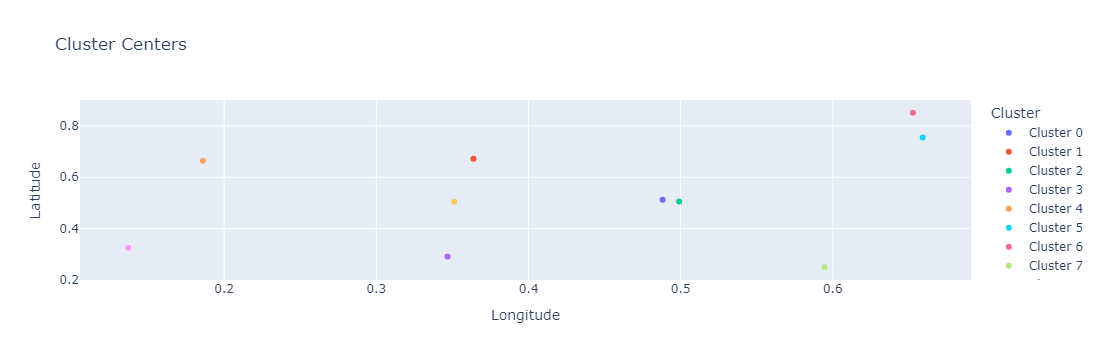

In [114]:
# Convert cluster centers to a DataFrame for easier plotting with Plotly
centers_df = pd.DataFrame({
    'Longitude': [center[0] for center in centers],
    'Latitude': [center[1] for center in centers],
    'Cluster': [f'Cluster {i}' for i in range(len(centers))]
})

# Create a scatter plot using Plotly Express
fig = px.scatter(centers_df, x='Longitude', y='Latitude', color='Cluster', 
                 title='Cluster Centers', labels={'Longitude': 'Longitude', 'Latitude': 'Latitude'})

# Show the plot
fig.show()

#### MRJob visualizations

In [12]:
# data got avg_fare_by_passengers_count.py file as map reduce function
total_fare_per_year_data = {
    "Passenger_Count": [1, 2, 3, 4, 5, 6, 7, 8, 9],
    "Average_Fare": [11.216405, 11.838421, 11.540597, 11.766069, 11.208401, 12.126156, 31.788667, 29.981111, 36.993043]
}

# Convert the dictionary into a DataFrame
fare_df = pd.DataFrame(total_fare_per_year_data)

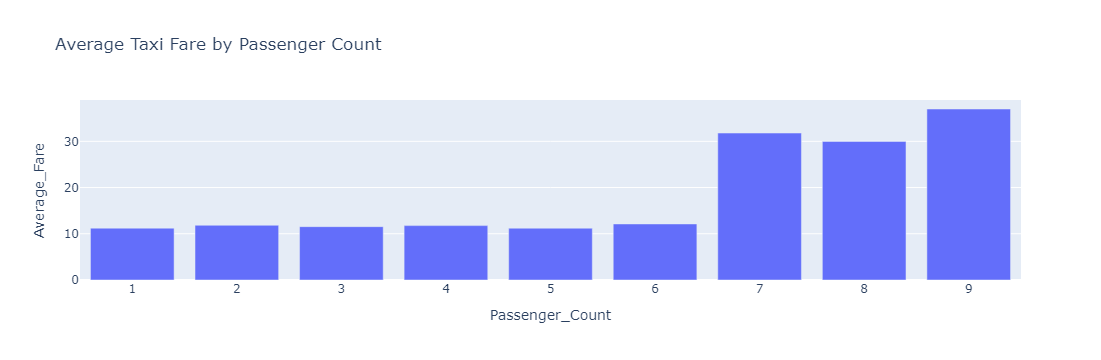

In [13]:
# Create a bar plot
fig = px.bar(fare_df, x='Passenger_Count', y='Average_Fare', title='Average Taxi Fare by Passenger Count')
fig.show()

In [14]:
# data got from total_fare_per_year.py file as map reduce function
total_fare_per_year_data = {
    "Year": ["2013", "2010", "2014", "2011", "2012", "2015", "2009"],
    "Total_Fare": [109084889.27, 84908545.81, 106627238.25, 92350274.46, 99682239.46, 50227425.29, 85905561.20]
}

total_fare_per_year_df = pd.DataFrame(total_fare_per_year_data)
# Sorting the DataFrame by Year
total_fare_per_year_df = total_fare_per_year_df.sort_values(by="Year")

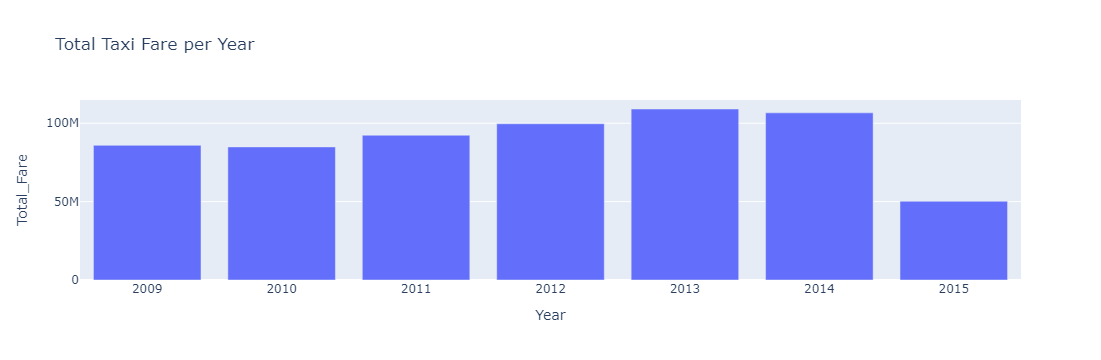

In [15]:
# Creating bar plot
fig_bar = px.bar(total_fare_per_year_df, x='Year', y='Total_Fare', title='Total Taxi Fare per Year')
fig_bar.show()

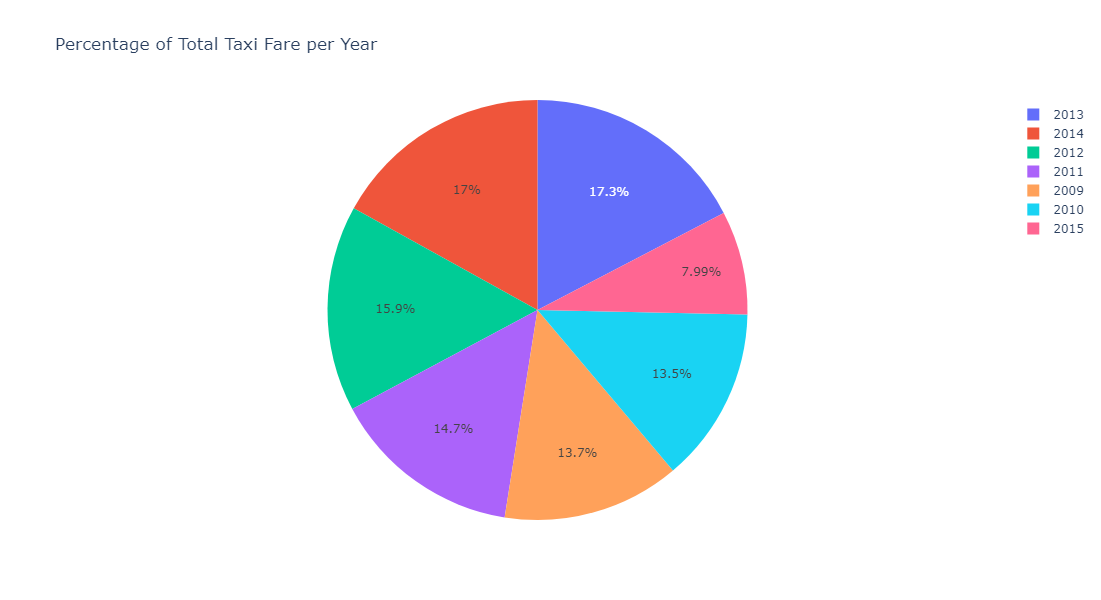

In [16]:
# Creating pie plot
fig_pie = px.pie(total_fare_per_year_df, names='Year', values='Total_Fare', title='Percentage of Total Taxi Fare per Year')

fig_pie.update_layout(
    autosize=False,
    width=800, 
    height=600 
)

fig_pie.show()